# IDENTIFICACIÓN Y CARACTERIZACIÓN DE MATERIALES 2D USANDO TÉCNICAS DE PROCESAMIENTO DE IMAGENES E INTELIGENCIA ARTIFICIAL

# Dependencias

In [ ]:
!pip install roboflow
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import cv2

import skimage as ski
import numpy as np
import pandas as pd
from roboflow import Roboflow

import sys
import shutil
import os
from pathlib import Path
from progressbar import progressbar as pbar
import joblib
import psutil
import gc

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mping
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage import img_as_ubyte
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tabulate import tabulate

import albumentations as A

from skimage.filters import gaussian

import tensorflow as tf
from keras.utils import to_categorical
from keras.utils import normalize
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Esta función nos permite verificar el estado de la RAM en todo momento.

In [ ]:
def check_ram_usage():
    ram = psutil.virtual_memory()
    total = ram.total / (1024 ** 3)  # Convert bytes to GB
    available = ram.available / (1024 ** 3)  # Convert bytes to GB
    used = (ram.total - ram.available) / (1024 ** 3)  # Convert bytes to GB
    print(f"Total RAM: {total:.2f} GB")
    print(f"Available RAM: {available:.2f} GB")
    print(f"Used RAM: {used:.2f} GB")

# Precarga de modelo y resultados

In [ ]:
def load_complete_model(model_path):
    """
    Load a complete model including architecture and weights
    Works with both .keras and .hdf5 files
    """
    try:
        model = load_model(model_path)
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

Descargamos el modelo

In [ ]:
!gdown https://drive.google.com/uc?id=1HCkZ6PzWRC_ZsiJaeiKUxBZ8rIsZDg6q -O unet_model_128_epoch_100.keras

Downloading...
From: https://drive.google.com/uc?id=1HCkZ6PzWRC_ZsiJaeiKUxBZ8rIsZDg6q
To: /content/unet_model_128_epoch_100.keras
100% 5.92M/5.92M [00:00<00:00, 88.0MB/s]


In [ ]:
model = load_complete_model('unet_model_128_epoch_100.keras')

Successfully loaded model from unet_model_128_epoch_100.keras


Descargamos el history

In [ ]:
!gdown https://drive.google.com/uc?id=1B8cEHCIHRp41U9_T-TpOlaWvNbNmKCC7 -O history_model128_epochs_100.joblib

Downloading...
From: https://drive.google.com/uc?id=1B8cEHCIHRp41U9_T-TpOlaWvNbNmKCC7
To: /content/history_model128_epochs_100.joblib
100% 5.93M/5.93M [00:00<00:00, 96.0MB/s]


In [ ]:
history = joblib.load('history_model128_epochs_100.joblib')

# Obtención de imágenes

In [ ]:
rf = Roboflow(api_key="YJeW9pVCy9nQ7BwHkRIO")
project = rf.workspace("2d-materials-segmentation").project("2d-materials-segmentation")
version = project.version(4)
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 2D-Materials-segmentation-4 in png-mask-semantic:: 100%|██████████| 88/88 [00:00<00:00, 1304.96it/s]


# Ordenamiento y renombrado de imágenes

In [ ]:
# Esta función renombra las imágenes las almacena dentro de la carpeta llamada img.
def rename_images(source_folder):
    # Create 'img' directory if it doesn't exist
    img_folder = os.path.join(source_folder, 'img')
    os.makedirs(img_folder, exist_ok=True)

    # Get all jpg files from source folder
    files = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]

    for filename in files:
        # Extract the number from the start of filename
        number = filename.split('_')[0]

        # Create new filename
        new_filename = f"{number}.jpg"

        # Source and destination paths
        source_path = os.path.join(source_folder, filename)
        dest_path = os.path.join(img_folder, new_filename)

        # Copy and rename the file
        try:
            shutil.copy2(source_path, dest_path)
            print(f"Copied and renamed: {filename} -> {new_filename}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

In [ ]:
# Esta función renombra las máscaras las almacena dentro de la carpeta llamada img.
def rename_mask_images(source_folder):
    # Create 'mask' directory if it doesn't exist
    mask_folder = os.path.join(source_folder, 'mask')
    os.makedirs(mask_folder, exist_ok=True)

    # Get all png files from source folder that contain '_mask.png'
    files = [f for f in os.listdir(source_folder) if f.endswith('_mask.png')]

    for filename in files:
        # Extract the number from the start of filename
        number = filename.split('_')[0]

        # Create new filename with _mask suffix
        new_filename = f"{number}_mask.png"

        # Source and destination paths
        source_path = os.path.join(source_folder, filename)
        dest_path = os.path.join(mask_folder, new_filename)

        # Copy and rename the file
        try:
            shutil.copy2(source_path, dest_path)
            print(f"Copied and renamed mask: {filename} -> {new_filename}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

In [ ]:
BASE_PATH = os.path.join(os.getcwd(), '2D-Materials-segmentation-4') # cuidado con este path
TRAIN_PATH = os.path.join(BASE_PATH,'train')
TEST_PATH = os.path.join(BASE_PATH,'test')
VALIDPATH = os.path.join(BASE_PATH,'valid')

Ejecutamos el trabajo para todas las carpetas

In [ ]:
def rename_job(path):
  print(f"Processing images in: {path}")
  rename_images(path)
  rename_mask_images(path)
  print("\nDone! Check the 'img' and 'mask' folders for renamed copies.")

In [ ]:
rename_job(TRAIN_PATH)
rename_job(TEST_PATH)
rename_job(VALIDPATH)

Processing images in: /content/2D-Materials-segmentation-4/train
Copied and renamed: 21_Grafeno-em-PDMS_Marco_060324_Amostra-2_20X_png_jpg.rf.c8d84e5c07516052b2d1a1b831e06a41.jpg -> 21.jpg
Copied and renamed: 17_Grafeno-em-PDMS_Maio_200524_Amostra-3_Floco-2_20X_png_jpg.rf.d40926e183630dd7761b7525daa8dbbd.jpg -> 17.jpg
Copied and renamed: 34_Grafeno-em-PDMS_Marco_260324_Amostra-2_Floco-2_20X_png_jpg.rf.5d19239dbeb37def6a904e13bb654c2a.jpg -> 34.jpg
Copied and renamed: 10_Grafeno-em-PDMS_Maio_070524_Amostra-2_20X_png_jpg.rf.f1e41ad994db59916f99e513aa84b338.jpg -> 10.jpg
Copied and renamed: 30_Grafeno-em-PDMS_Marco_200324_Amostra-2_Floco-1_20X_png_jpg.rf.1609f3977a0c5d99c10579df13598601.jpg -> 30.jpg
Copied and renamed: 29_Grafeno-em-PDMS_Marco_200324_Amostra-1_20X_png_jpg.rf.989e61b765060aa6b77407e882d3a082.jpg -> 29.jpg
Copied and renamed: 32_Grafeno-em-PDMS_Marco_260324_Amostra-1_Floco-1_20X_png_jpg.rf.61bfa7a8e4a02a85c63c18fcc7be1ce1.jpg -> 32.jpg
Copied and renamed: 20_Grafeno-em-PDM

Verificamos que los pares de imágenes si coicidan

In [ ]:
TRAIN_IMG_PATH = os.path.join(TRAIN_PATH, 'img')
TRAIN_MASK_PATH = os.path.join(TRAIN_PATH, 'mask')
TEST_IMG_PATH = os.path.join(TEST_PATH, 'img')
TEST_MASK_PATH = os.path.join(TEST_PATH, 'mask')
VALID_IMG_PATH = os.path.join(VALIDPATH, 'img')
VALID_MASK_PATH = os.path.join(VALIDPATH, 'mask')

In [ ]:
def verify_pairs(idx, path_img, path_mask, cmap = None):
    try:
        img = imread(os.path.join(path_img, f"{idx}.jpg"))
        mask = imread(os.path.join(path_mask, f"{idx}_mask.png"))

        fig, axes = plt.subplots(1, 2, figsize=(6.4, 4.6))
        axes[0].imshow(img, cmap = cmap)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(mask, cmap = cmap)
        axes[1].set_title("Mask")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("No se encontraron imágenes")

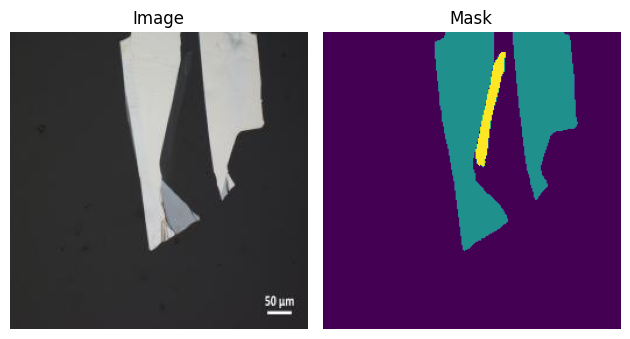

In [ ]:
# Los valores válidos los da os.listdir(PATH),
# Luego sólo pones el número.
# Más adelante se encapsulan los valores, por lo que este proces oes sólo para
# Verificar que el proceso anteriore esté bien
idx = 5 # Cambiar este valor para mostrar pares imagen-máscara!
verify_pairs(idx, TRAIN_IMG_PATH, TRAIN_MASK_PATH)

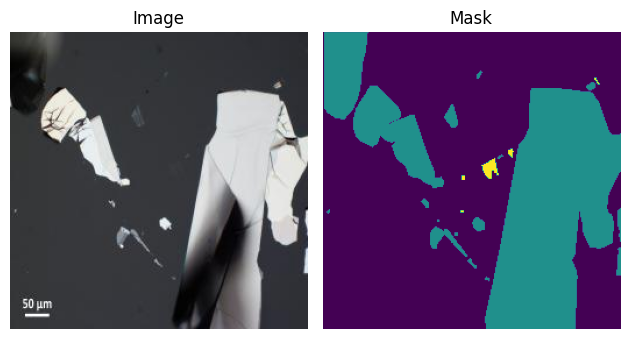

In [ ]:
# Los valores válidos los da os.listdir(PATH),
# Luego sólo pones el número.
# Más adelante se encapsulan los valores, por lo que este proces oes sólo para
# Verificar que el proceso anteriore esté bien
idx = 11 # Cambiar este valor para mostrar pares imagen-máscara!
verify_pairs(idx, TEST_IMG_PATH, TEST_MASK_PATH)

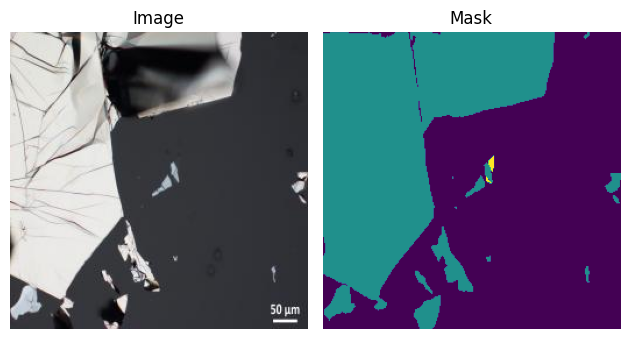

In [ ]:
# Los valores válidos los da os.listdir(PATH),
# Luego sólo pones el número.
# Más adelante se encapsulan los valores, por lo que este proces oes sólo para
# Verificar que el proceso anteriore esté bien
idx = 13 # Cambiar este valor para mostrar pares imagen-máscara!
verify_pairs(idx, VALID_IMG_PATH, VALID_MASK_PATH)

# Preparación de imágenes

Para construir las variables que almacenarán las imágenes, se debe tener referencia a los pares imagen-máscara. Por eso se contruirá un diccionario que almacenará estos pares. Aunque este paso no es estrictamente necesario, se hace para tener etos pares de forma encapsulada, para posteriormente acceder a estos de forma más segura.

## Empaquetado de referencias

In [ ]:
def build_pairs_dict(path_img, path_mask):
  pairs = {}
  for idx in pbar(os.listdir(path_img)):
    img_path = os.path.join(path_img, idx)
    mask_path = os.path.join(path_mask, idx.split('.')[0] + '_mask.png')
    pairs[idx] = {'img': img_path, 'mask': mask_path}
  return pairs

In [ ]:
def create_image_mask_mapping(img_folder: str, mask_folder: str) -> dict:
    """
    Creates a dictionary mapping image numbers to their respective image and mask paths.

    Args:
        img_folder (str): Path to the folder containing original images
        mask_folder (str): Path to the folder containing mask images

    Returns:
        dict: Dictionary with the structure {number: {"img": img_path, "mask": mask_path}}
    """
    # Convert to Path objects for easier path manipulation
    img_path = Path(img_folder)
    mask_path = Path(mask_folder)

    # Initialize the result dictionary
    mapping = {}

    # Get all image files
    img_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

    for img_file in img_files:
        # Extract the number from the image filename
        # Se asume que las imágenes tienen la siguiente estructura
        # <number>.jpg
        number = img_file.split('.')[0]
        number = int(number) # We know that the numbers are integers.

        # Construct the corresponding mask filename
        mask_file = f"{number}_mask.png"

        # Only add to mapping if both image and mask exist
        # The / operator in this context is a special operator for Path objects
        # from the pathlib module. It's used for path concatenation - joining
        # paths together in a way that works across different operating systems.
        if os.path.exists(mask_path / mask_file):
            mapping[number] = {
                "img": str(img_path / img_file),
                "mask": str(mask_path / mask_file)
            }

    return mapping


In [ ]:
# Example paths - replace with your actual paths
img_folder = TRAIN_IMG_PATH
mask_folder = TRAIN_MASK_PATH

TRAIN_REF_DICT = create_image_mask_mapping(img_folder, mask_folder)

# Print the result in a formatted way
for number, paths in TRAIN_REF_DICT.items():
    print(f"\nImage {number}:")
    print(f"  Image path: {paths['img']}")
    print(f"  Mask path: {paths['mask']}")


Image 36:
  Image path: /content/2D-Materials-segmentation-4/train/img/36.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/36_mask.png

Image 12:
  Image path: /content/2D-Materials-segmentation-4/train/img/12.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/12_mask.png

Image 17:
  Image path: /content/2D-Materials-segmentation-4/train/img/17.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/17_mask.png

Image 4:
  Image path: /content/2D-Materials-segmentation-4/train/img/4.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/4_mask.png

Image 39:
  Image path: /content/2D-Materials-segmentation-4/train/img/39.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/39_mask.png

Image 14:
  Image path: /content/2D-Materials-segmentation-4/train/img/14.jpg
  Mask path: /content/2D-Materials-segmentation-4/train/mask/14_mask.png

Image 19:
  Image path: /content/2D-Materials-segmentation-4/train/img/19.jpg
  Mask path:

In [ ]:
TEST_REF_DICT = create_image_mask_mapping(TEST_IMG_PATH, TEST_MASK_PATH)
VAL_REF_DICT = create_image_mask_mapping(VALID_IMG_PATH, VALID_MASK_PATH)

Con estos diccionarios tenemos accesso en todo momento a las parejas imágen-máscara, y facilitamos su acceso. El siguiente paso será acplicar el aumentado de las imágenes sobre el conjunto de imágenes de 'train' y de 'test'

In [ ]:
def plot_img_mask_path(img_path, mask_path, cmap = None):
    try:
      img = imread(img_path)
      mask = imread(mask_path)
    except:
      print("No se encontraron imagenes")
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs[0].imshow(img)
    axs[0].set_title('Image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap = cmap )
    axs[1].set_title('Mask')
    axs[1].axis('off')
    plt.show()

In [ ]:
def plot_img_mask(img, mask, cmap = None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs[0].imshow(img)
    axs[0].set_title('Image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap = cmap )
    axs[1].set_title('Mask')
    axs[1].axis('off')
    plt.show()

{'img': '/content/2D-Materials-segmentation-4/train/img/31.jpg', 'mask': '/content/2D-Materials-segmentation-4/train/mask/31_mask.png'}


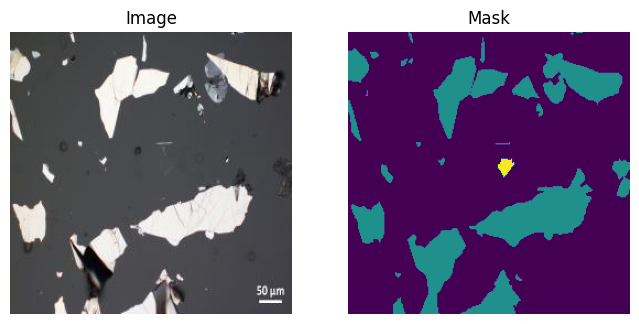

In [ ]:
ref_dict = TRAIN_REF_DICT # Cambiar por TEST or VALID
idx = np.random.choice(list(ref_dict.keys())) # Random pick
print(ref_dict[idx])
plot_img_mask_path(ref_dict[idx]['img'], ref_dict[idx]['mask'])

## Construcción de Datasets

Ya tenemos las referencias a los pares imagen-máscara. El siguiente paso es prepararlas para que sean digeridas por el modelo. A continuación desempaquetamos los diccionarios.

In [ ]:
def get_dataset_from_ref_dict(ref_dict: dict):
  images_paths = [ref_dict[number]["img"] for number in ref_dict]
  masks_paths = [ref_dict[number]["mask"] for number in ref_dict]
  images = np.array([imread(path) for path in images_paths])
  masks = np.array([imread(path) for path in masks_paths])
  return images, masks

In [ ]:
train_imgs, train_masks = get_dataset_from_ref_dict(TRAIN_REF_DICT)
test_imgs, test_masks = get_dataset_from_ref_dict(TEST_REF_DICT)
val_imgs, val_masks = get_dataset_from_ref_dict(VAL_REF_DICT)

In [ ]:
print("train shapes:", train_imgs.shape, "train masks shape:", train_masks.shape)
print("test shapes:", test_imgs.shape, "test masks shape:", test_masks.shape)
print("val shapes:", val_imgs.shape, "val masks shape:" ,val_masks.shape)

train shapes: (32, 256, 256, 3) train masks shape: (32, 256, 256)
test shapes: (5, 256, 256, 3) test masks shape: (5, 256, 256)
val shapes: (3, 256, 256, 3) val masks shape: (3, 256, 256)


In [ ]:
check_ram_usage()

Total RAM: 12.67 GB
Available RAM: 10.99 GB
Used RAM: 1.69 GB


## Image Augmentation

Vamos a aplicar Image augmentation sobre las listas de imágenes obtenidas.

In [ ]:
def zeros_arr_generator(size, max_iter=50):
    """
    Generates a random array of integers of the specified size with values between 0 and 1,
    and ensures that the array contains at least one non-zero element. If no non-zero element
    is found after `max_iter` iterations, the function will return the last generated array.

    Args:
        size (int or tuple of ints): The shape of the array to be generated. Can be an integer
                                      for a 1D array or a tuple for a multi-dimensional array.
        max_iter (int, optional): The maximum number of iterations to attempt generating a valid
                                  array. Defaults to 10.

    Returns:
        numpy.ndarray: A random integer array of shape `size` containing at least one non-zero element.

    Raises:
        ValueError: If no valid array is found within `max_iter` iterations (all arrays generated
                    are full of zeros).
    """
    for i in range(max_iter):
        random_array = np.random.randint(2, size=size)  # Generate a random array with 0s and 1s
        if not np.all(random_array == 0):  # Check if the array has at least one non-zero element
            return random_array

    # If no valid array was found after max_iter attempts, raise an error
    raise ValueError(f"Unable to generate an array with non-zero elements after {max_iter} attempts.")

In [ ]:
def augment_image_V2(image: np.ndarray, mask: np.ndarray, N: int):
    """
    Augments an input image and its corresponding mask using a series of transformations,
    and generates N augmented versions of the image and mask.

    The transformations applied to the image and mask include:
    1. Gaussian noise
    2. Random brightness and contrast adjustments
    3. Random rotation (between -90 and 90 degrees)
    4. Random horizontal flip

    The probability of each transformation being applied is determined by a randomly generated
    array of probabilities, which are generated by the `zeros_arr_generator` function.

    Args:
        image (np.ndarray): The input image to augment. It is assumed to be a numpy array.
        mask (np.ndarray): The corresponding mask for the input image. It should have the same
                            shape as the image.
        N (int): The number of augmented image-mask pairs to generate.

    Returns:
        tuple: A tuple containing two lists:
            - `augment_images` (list): A list of N augmented images.
            - `augment_masks` (list): A list of N augmented masks.

    Raises:
        AssertionError: If the number of transformations in the augmentation pipeline does not
                        match the expected number of transformations (4 in this case).

    Notes:
        - The function uses the `albumentations` library (`A.Compose`) to apply a sequence of
          transformations to both the image and the mask.
        - The probability of each transformation being applied is randomly generated by
          `zeros_arr_generator`, a helper function that returns a list of probabilities.
        - The exact transformations applied may vary for each augmented image-mask pair.
    """
    def build_transform_pipeline():
        """
        Builds and returns an augmentation pipeline with randomly generated transformation
        probabilities for each of the defined transformations.

        The pipeline includes the following transformations:
        1. Gaussian noise (`A.GaussNoise`)
        2. Random brightness and contrast adjustment (`A.RandomBrightnessContrast`)
        3. Random rotation (`A.Rotate`)
        4. Horizontal flip (`A.HorizontalFlip`)

        Returns:
            A.Compose: The albumentations transformation pipeline with randomly set probabilities.
        """
        arr_len = 4  # Define the number of transformations in the pipeline
        probs = zeros_arr_generator(arr_len)  # Generate random probabilities for each transformation

        # Define the augmentation pipeline using albumentations
        transform = A.Compose([
            A.GaussNoise(p=probs[0]),  # Apply Gaussian noise with a certain probability
            A.RandomBrightnessContrast(p=probs[1]),  # Apply random brightness/contrast change
            A.Rotate(p=probs[2]),  # Apply random rotation with a certain probability
            A.HorizontalFlip(p=probs[3]),  # Apply random horizontal flip
        ])

        # Ensure the number of transformations matches the expected count
        error_msg = "arr_len debe tener la misma cantidad de trasnformaciones "
        assert len(transform.get_dict_with_id()['transforms']) == arr_len, error_msg

        return transform


    augment_images = []  # List to store augmented images
    augment_masks = []  # List to store augmented masks

    # Generate N augmented image-mask pairs
    for i in range(N):
        transform = build_transform_pipeline()  # Build the transformation pipeline
        transform_result = transform(image=image, mask=mask)  # Apply transformations to image and mask
        augment_images.append(transform_result["image"])  # Append the augmented image
        augment_masks.append(transform_result["mask"])  # Append the augmented mask

    # Return the augmented image-mask pairs
    return augment_images, augment_masks


Aplciamos un filtro Gaussiano, pero podría ser otro filtro. Es importante definir la función, ya que en el pipeline se hace llamado a la función que define el filtro.

In [ ]:
def apply_gaussian_filter(image, sigma=1.0):
    """
    Apply Gaussian filter to an image using scikit-image.

    Args:
    - image (np.ndarray): Input image (can be RGB or grayscale).
    - sigma (float): Standard deviation of the Gaussian filter.
                     Larger values result in stronger blur.

    Returns:
    - blurred_image (np.ndarray): The blurred image.
    """
    # Apply Gaussian filter
    blurred_image = gaussian(image, sigma=sigma)
    blurred_image_uint8 = (blurred_image * 255).astype(np.uint8)
    return blurred_image_uint8

In [ ]:
def augmentation_pipeline(imgs: list, masks: list, filter_callback, N: int = 10):
    """
    Applies an augmentation pipeline to a list of images and their corresponding masks.

    This function generates augmented images and masks by applying a specified
    augmentation method to each image-mask pair. It also allows for an optional
    filtering step on the augmented images using a callback function.

    Parameters:
    - imgs (list): A list of input images to be augmented.
    - masks (list): A list of corresponding masks for each input image.
    - N (int): The number of augmentations to generate for each image-mask pair.
    - filter_callback (callable, optional): A callback function that takes an image
      as input and returns a filtered image. If None, a default Gaussian filter
      with sigma=0.7 will be applied.

    Returns:
    - final_images (list): A list containing the original and augmented images
      after filtering.
    - final_masks (list): A list containing the original and augmented masks.

    Example:
    >>> augmented_images, augmented_masks = augmentation_pipeline(images, masks, N=5)

    Notes:
    - The function uses `augment_image` to generate augmentations for each image-mask pair.
    - The filtering is applied to both the original and augmented images before they are returned.
    """

    apply_filter = filter_callback

    final_images = []
    final_masks = []

    for i, m in zip(imgs, masks):
        # Generate augmented images and masks
        augment_images, augment_masks = augment_image_V2(i, m, N)

        # Concatenate original and augmented images/masks
        concat_imgs = [i] + augment_images
        concat_masks = [m] + augment_masks

        # Apply the specified filter to each concatenated image
        concat_imgs_filtered = list(map(apply_filter, concat_imgs))

        # Append filtered images and original/augmented masks to final lists
        final_images += concat_imgs_filtered  # Append filtered imgs
        final_masks += concat_masks            # Append masks

    return np.array(final_images), np.array(final_masks)

In [ ]:
gaussian_filter = lambda x: apply_gaussian_filter(x, sigma=0.3) # Callback para el filtro
X_train, y_train = augmentation_pipeline(train_imgs, train_masks, gaussian_filter, 50)

In [ ]:
# GC y verificamos RAM
gc.collect()
check_ram_usage()

Total RAM: 12.67 GB
Available RAM: 10.48 GB
Used RAM: 2.20 GB


In [ ]:
X_train.shape, y_train.shape

((1632, 256, 256, 3), (1632, 256, 256))

Observe que para 32 imágenes, generamos 50 por cada imagen, sumado con la imágen original. Debe cumplirse la correspondencia 1-1 entre las imágenes y las máscaras.

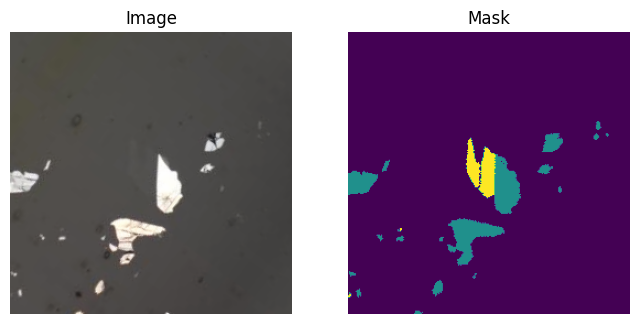

In [ ]:
# Ejecutar varias veces para verificar
idx = np.random.randint(0, X_train.shape[0])
plot_img_mask(X_train[idx], y_train[idx])

Aumentamos el dataset de test y validation

In [ ]:
X_test, y_test = augmentation_pipeline(test_imgs, test_masks, gaussian_filter, 10)
X_val, y_val = augmentation_pipeline(val_imgs, val_masks, gaussian_filter, 5) # No necesitamos muchas para validacion

In [ ]:
X_test.shape, y_test.shape

((55, 256, 256, 3), (55, 256, 256))

In [ ]:
X_val.shape, y_val.shape

((18, 256, 256, 3), (18, 256, 256))

Verificamos que las mácaras solo tengan tres valores únicos

In [ ]:
np.unique(y_train), np.unique(y_test), np.unique(y_val)

(array([0, 1, 2], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1, 2], dtype=uint8))

Estad definiciones nos servirán posteriormente.

In [ ]:
N_CLASSES = len(np.unique(y_val))
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
print("Number of classes:", N_CLASSES)
print("Img height",IMG_HEIGHT )
print("Img width",IMG_WIDTH )
print("Img channels",IMG_CHANNELS )

Number of classes: 3
Img height 256
Img width 256
Img channels 3


## Normalziación y One-Hot Encoding

In [ ]:
# Input images (features):
#X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_train_norm = (X_train/255.0).astype(np.float32)

#X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_test_norm = (X_test/255.0).astype(np.float32)

#X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_val_norm = (X_val/255.0).astype(np.float32)

In [ ]:
gc.collect()
check_ram_usage()

Total RAM: 12.67 GB
Available RAM: 9.25 GB
Used RAM: 3.43 GB


One-Hot a las Máscaras


In [ ]:
def one_hot_encode_batch(batch_images, num_classes):
    """
    One-hot encodes a batch of 2D images with pixel values as class indices.

    Args:
        batch_images (numpy.ndarray): A 3D array of shape (N, H, W) containing class indices.
        num_classes (int): Total number of classes.

    Returns:
        numpy.ndarray: A 4D array of shape (N, H, W, num_classes) with one-hot encoding (dtype: uint8).
    """
    # Ensure the images contain valid class indices
    if np.any(batch_images < 0) or np.any(batch_images >= num_classes):
        raise ValueError("Batch contains invalid class indices.")

    # Perform one-hot encoding and cast to uint8 due to RAM issues
    one_hot = np.eye(num_classes, dtype=np.uint8)[batch_images]
    return one_hot

In [ ]:
# y_train_encoded = tf.one_hot(y_train, depth=3)
# y_train_encoded = tf.cast(y_train_encoded, dtype=tf.int32)
y_train_encoded = one_hot_encode_batch(y_train, N_CLASSES)
gc.collect()

# y_test_encoded = tf.one_hot(y_test, depth=3)
# y_test_encoded = tf.cast(y_test_encoded, dtype=tf.int32)
y_test_encoded = one_hot_encode_batch(y_test, N_CLASSES)
gc.collect()

# y_val_encoded = tf.one_hot(y_val, depth=3)
# y_val_encoded = tf.cast(y_val_encoded, dtype=tf.int32)
y_val_encoded = one_hot_encode_batch(y_val, N_CLASSES)
gc.collect()

y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((1632, 256, 256, 3), (55, 256, 256, 3), (18, 256, 256, 3))

Sólo vamos usar las variables que contienen las imágenes normalizadas, y las máscaras codificadas. Debemos liberar RAM para el entrenamiento.

In [ ]:
#del X_train, y_train, X_test, y_test, train_imgs, train_masks, test_imgs, test_masks, val_imgs, val_masks
gc.collect()
check_ram_usage()

Total RAM: 12.67 GB
Available RAM: 8.98 GB
Used RAM: 3.70 GB


# Entrenamiento

In [ ]:
def multi_unet_model128(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    """
    Función para crear el modelo UNet con 128 neuronas de profundidad
    """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Expansion path
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

**OJO** Si se desea volver a entrenar, descomenta esta celda. Hacer esto pierde referencia al modelo precargado.

In [ ]:
# model = multi_unet_model128(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy', 'Precision', 'Recall'], )

# model.summary()

In [ ]:
gc.collect()

0

In [ ]:
# Entrenamiento del modelo durante 100 épocas
# Descomentar si se desea realizar el proceso de entrenamiento

# history = model.fit(
#     X_train_norm,
#     y_train_encoded,
#     validation_data=(X_test_norm, y_test_encoded),
#     batch_size = 32,
#     verbose = 1,
#     epochs = 100)

#model.save('unet_model128_epoch_100.keras')

## Resultados Entrenamiento

In [ ]:
def plot_history(history, key:str):
  #plot the training and validation accuracy and loss at each epoch
  loss = history.history[key]
  val_loss = history.history['val_'+key]
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label=f'Training {key}')
  plt.plot(epochs, val_loss, 'r', label=f'Validation {key}')
  plt.title(f'Training and validation {key}')
  plt.xlabel('Epochs')
  plt.ylabel(key)
  plt.legend()
  plt.show()

In [ ]:
history.history.keys()

dict_keys(['Precision', 'Recall', 'accuracy', 'loss', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])

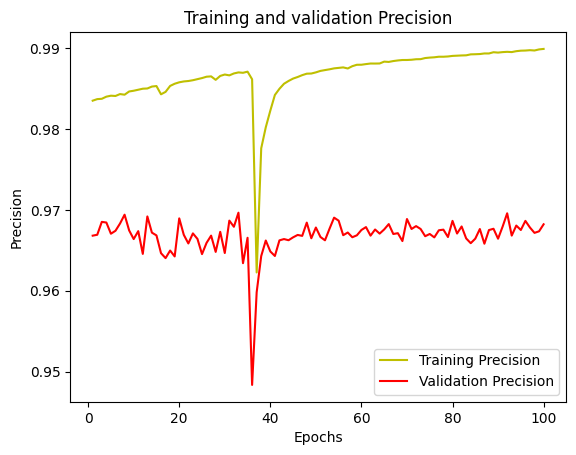

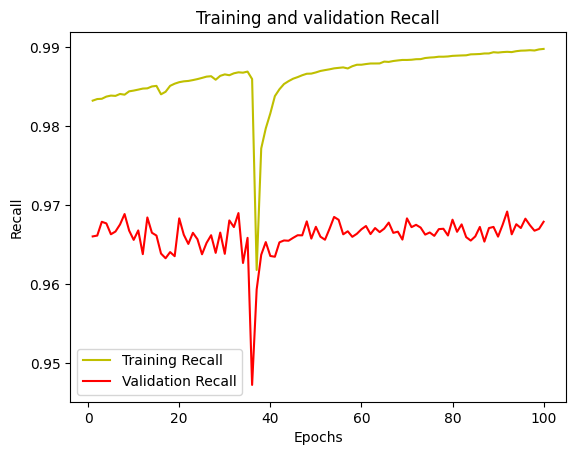

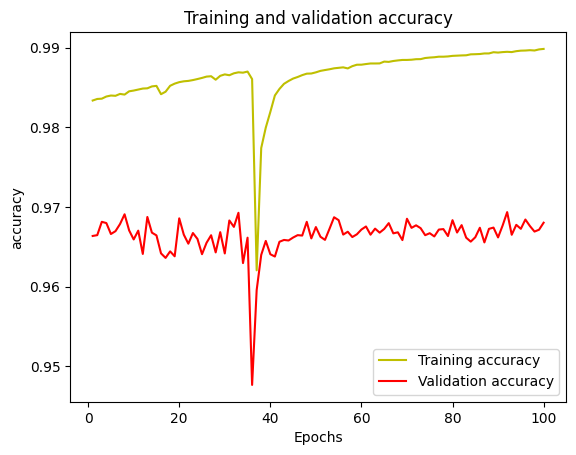

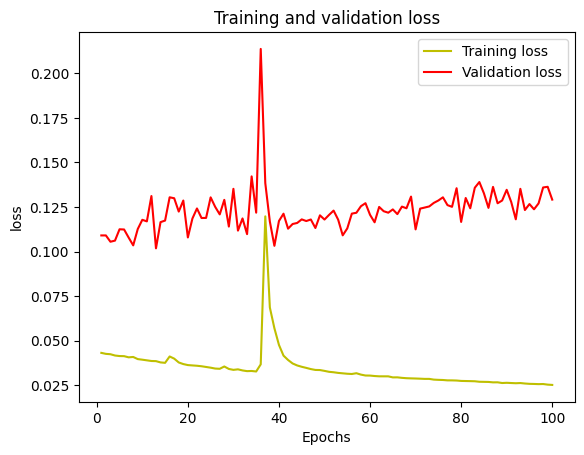

In [ ]:
for key in ['Precision', 'Recall', 'accuracy', 'loss']:
  plot_history(history, key)

# Verificación

Vamos a revisar los resultados obtenidos con el conjunto de validación.

In [ ]:
#Evaluate the model
model_eval = model.evaluate(X_val_norm, y_val_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Precision: 0.9795 - Recall: 0.9793 - accuracy: 0.9794 - loss: 0.0731


In [ ]:
def calculate_iou(pred_mask, true_mask, num_classes):
    """
    Calculate the Intersection over Union (IoU) for each class in semantic segmentation.

    Parameters:
    pred_mask (np.array): Predicted segmentation mask (2D array).
    true_mask (np.array): Ground truth segmentation mask (2D array).
    num_classes (int): Number of classes in the segmentation task.

    Returns:
    np.array: IoU score for each class.
    """

    # Initialize IoU array
    iou_scores = np.zeros(num_classes)

    # Loop through each class
    for cls in range(num_classes):
        # Create binary masks for the current class
        pred_cls = (pred_mask == cls).astype(int)
        true_cls = (true_mask == cls).astype(int)

        # Calculate intersection and union
        intersection = np.sum(pred_cls * true_cls)
        union = np.sum(pred_cls) + np.sum(true_cls) - intersection

        # Calculate IoU, avoiding division by zero
        if union == 0:
            iou_scores[cls] = 0.0  # No ground truth or prediction for this class
        else:
            iou_scores[cls] = intersection / union

    return iou_scores


In [ ]:
def calculate_iou(pred_mask, gt_mask, num_classes):
    """
    Calculate Intersection over Union (IoU) for each class in semantic segmentation.

    Parameters:
        pred_mask (np.ndarray): Predicted segmentation mask (H, W), where H and W are height and width.
        gt_mask (np.ndarray): Ground truth segmentation mask (H, W).
        num_classes (int): Number of classes (including background).

    Returns:
        iou_per_class (dict): Dictionary where the key is the class index, and value is the IoU for that class.
        mean_iou (float): Mean IoU across all classes.
    """
    iou_per_class = {}
    for i in range(num_classes):
        # Binary masks for current class
        pred_class = (pred_mask == i).astype(np.uint8)
        gt_class = (gt_mask == i).astype(np.uint8)

        # Intersection: Pixels that are both predicted as class 'i' and ground truth is class 'i'
        intersection = np.sum(np.logical_and(pred_class == 1, gt_class == 1))

        # Union: Pixels that are predicted as class 'i' OR ground truth is class 'i'
        union = np.sum(np.logical_or(pred_class == 1, gt_class == 1))

        # IoU calculation for current class
        iou = intersection / float(union) if union != 0 else 0
        iou_per_class[i] = iou

    # Compute mean IoU across all classes
    mean_iou = np.mean(list(iou_per_class.values()))
    return iou_per_class, mean_iou

Vamos a generar una predicción por cada imágen en el conjunto de validación, para construir una lista de dimensiones (N, H, W). Esto lo usaremos para calcular las métricas.

In [ ]:
def build_predicitions(val_imgs, model):
  y_pred = []
  for i in range(len(val_imgs)):
    pred = model.predict(np.expand_dims(val_imgs[i],axis=0))
    pred = np.argmax(pred, axis=3)
    pred = np.squeeze(pred, axis=0)
    y_pred.append( pred )
  return np.array(y_pred).astype( np.uint8 )

In [ ]:
y_pred = build_predicitions(X_val_norm, model)
y_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


(18, 256, 256)

In [ ]:
#calculate_iou(np.squeeze(y_pred_argmax, axis=0), np.squeeze(y_val[0]), N_CLASSES)

Ejecutar varias veces la siguiente celda para verificar

In [ ]:
def plot_validation(val_data, y_true, y_pred, idx, cmap = None):
    """
    Plots an image, its true mask, and the predicted mask for a given index.

    Parameters:
    - val_data: ndarray of shape (N, H, W), the batch of input images.
    - y_true: ndarray of shape (N, H, W), the batch of ground-truth masks.
    - y_pred: ndarray of shape (N, H, W), the batch of predicted masks.
    - idx: int, the index of the sample to visualize.

    Returns:
    - None, displays the plot.
    """
    try:
        # Extract specific sample
        img = val_data[idx]
        true_mask = y_true[idx]
        pred_mask = y_pred[idx]


        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f"Sample Index: {idx}", fontsize=16, y = 0.90)

        axes[0].imshow(img, cmap = cmap)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(true_mask, cmap = cmap)
        axes[1].set_title("True Mask")
        axes[1].axis("off")

        axes[2].imshow(pred_mask, cmap=cmap)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Index {idx} is out of bounds for the provided data.")

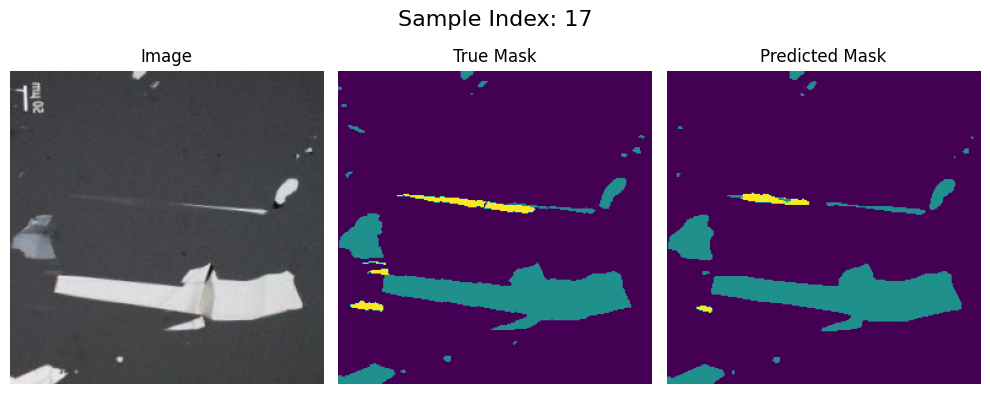

In [ ]:
# Ejecutar varias veces para probar
# Ejemplos:
idx = np.random.choice(list(range(y_val.shape[0])))
plot_validation(X_val, y_val, y_pred, idx)

## Matriz de Confusión

In [ ]:
def compute_segmentation_confusion_matrix(y_true, y_pred, num_classes, normalize=False):
    """
    Compute confusion matrix for semantic segmentation task.

    Parameters:
    -----------
    y_true : numpy.ndarray
        Ground truth masks (H, W) or (N, H, W)
    y_pred : numpy.ndarray
        Predicted masks (H, W) or (N, H, W)
    num_classes : int
        Number of classes (including background)
    normalize : bool, optional
        Whether to normalize the confusion matrix

    Returns:
    --------
    numpy.ndarray
        Confusion matrix of shape (num_classes, num_classes)
    """
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis, ...]
        y_pred = y_pred[np.newaxis, ...]

    # Flatten all predictions and ground truth masks
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()

    # Compute confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=range(num_classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return cm

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix with nice formatting.

    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix
    class_names : list
        List of class names
    title : str, optional
        Title for the plot
    """

    # Visualizar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matriz de Confusión")
    plt.show()

    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='.2f' if cm.dtype.kind == 'f' else 'd',
    #             cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.title(title)
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.tight_layout()

def compute_metrics(cm):
    """
    Compute various metrics from confusion matrix.

    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix

    Returns:
    --------
    dict
        Dictionary containing various metrics
    """
    # Per-class metrics
    metrics = {}
    n_classes = cm.shape[0]

    for i in range(n_classes):
        # True Positives, False Positives, False Negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = np.sum(cm) - tp - fp - fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[f'class_{i}'] = {
            'precision': precision,
            'accuracy': accuracy,
            'recall': recall,
            'iou': iou,
            'f1_score': f1
        }

    # Mean metrics
    metrics['mean'] = {
        'precision': np.mean([m['precision'] for m in metrics.values()]),
        'accuracy': np.mean([m['accuracy'] for m in metrics.values()]),
        'recall': np.mean([m['recall'] for m in metrics.values()]),
        'iou': np.mean([m['iou'] for m in metrics.values()]),
        'f1_score': np.mean([m['f1_score'] for m in metrics.values()]),
    }

    # Standar deviation
    metrics['std'] = {
        'precision': np.std([m['precision'] for m in metrics.values()]),
        'accuracy': np.std([m['accuracy'] for m in metrics.values()]),  # Mean per-class accuracy
        'recall': np.std([m['recall'] for m in metrics.values()]),
        'iou': np.std([m['iou'] for m in metrics.values()]),
        'f1_score': np.std([m['f1_score'] for m in metrics.values()]),
    }

    return metrics

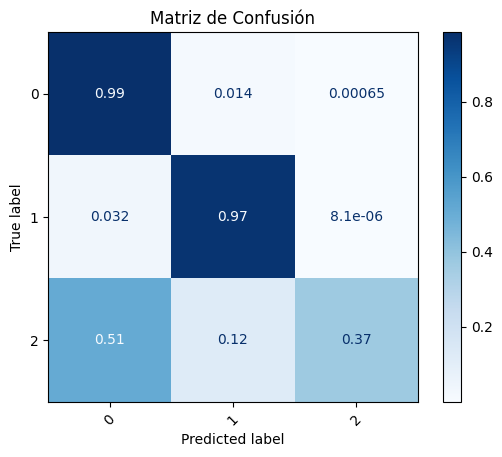

In [ ]:
# Compute confusion matrix
cm = compute_segmentation_confusion_matrix(y_val, y_pred, num_classes=3, normalize=True)

# Plot confusion matrix
class_names = ['0', '1', '2']
plot_confusion_matrix(cm, class_names, 'Segmentation Confusion Matrix')

## Reporte final de métricas

In [ ]:
def print_metrics_table(metrics, class_names=None):
    """
    Print metrics in a nicely formatted table using tabulate.

    Parameters:
    -----------
    metrics : dict
        Dictionary containing the metrics from compute_metrics
    class_names : list, optional
        List of class names for better reporting
    """
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(metrics) - 2)]  # -2 for mean and std

    # Create DataFrame for better organization
    data = []

    # Add per-class metrics
    for i, class_name in enumerate(class_names):
        row = metrics[f'class_{i}']
        row['Class'] = class_name
        data.append(row)

    # Add mean and std
    metrics['mean']['Class'] = 'Mean'
    metrics['std']['Class'] = 'Std'
    data.append(metrics['mean'])
    data.append(metrics['std'])

    # Create DataFrame
    df = pd.DataFrame(data)

    # Reorder columns
    columns = ['Class', 'accuracy', 'precision', 'recall', 'f1_score', 'iou']
    df = df[columns]

    # Round values
    numeric_columns = ['accuracy', 'precision', 'recall', 'f1_score', 'iou']
    df[numeric_columns] = df[numeric_columns].round(3)

    # Convert to table format
    table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)

    # Add title
    title = "Segmentation Metrics"
    print(f"\n{title}")
    print("=" * len(title))
    print(table)

In [ ]:
# Compute and print metrics
metrics = compute_metrics(cm)
print_metrics_table(metrics, class_names)


Segmentation Metrics
╒═════════╤════════════╤═════════════╤══════════╤════════════╤═══════╕
│ Class   │   accuracy │   precision │   recall │   f1_score │   iou │
╞═════════╪════════════╪═════════════╪══════════╪════════════╪═══════╡
│ 0       │      0.815 │       0.645 │    0.986 │      0.78  │ 0.64  │
├─────────┼────────────┼─────────────┼──────────┼────────────┼───────┤
│ 1       │      0.944 │       0.877 │    0.968 │      0.92  │ 0.852 │
├─────────┼────────────┼─────────────┼──────────┼────────────┼───────┤
│ 2       │      0.789 │       0.998 │    0.369 │      0.538 │ 0.368 │
├─────────┼────────────┼─────────────┼──────────┼────────────┼───────┤
│ Mean    │      0.849 │       0.84  │    0.774 │      0.746 │ 0.62  │
├─────────┼────────────┼─────────────┼──────────┼────────────┼───────┤
│ Std     │      0.059 │       0.127 │    0.248 │      0.137 │ 0.171 │
╘═════════╧════════════╧═════════════╧══════════╧════════════╧═══════╛


# Conclusiones

Se comienza a hacer detección de la clase de interés, que es la Few-Layer. Sin embargo, en algunos casos, no se logra detectar, por lo que el resultado de la predicción arroja una máscara con sólo dos valores únicos, por lo que hay que
tener cuidado con esto a la hora imprimir en pantalla.

*   0 -> Background
*   1 -> bulk
*   2 -> Few Layer

Se puede intentar mejorar agregando una función de pérdida personalizada para que tome en cuenta los pesos de las clases, ya que no fue posible agregar esta parte en el proceso de entrenamiento. Además, no fue posible ingresar la métrica F1 directamente en la compilación del modelo.

Es importante resaltar el papel de la métrica IOU, porque como se pudo observar, las métricas estándar dan resultados "muy buenos" en algunas clases, pero estas tienen limitaciones, especialmente con datasets desbalanceados, y en el contexto del problema, es mejor la métrica IoU.

Finalmente, se podría generar más imágenes sintéticas, o incluso aumentar el tamaño de las imágenes (en este nb se usaron imágenes de 256x256) a imágenes de 512x512, pero hay que tener mucho cuidado con la memoria RAM.